## Spike sorting demo for BRW files
----

https://gist.github.com/mhhennig/97453faec66ea78f96e61a193f699e6c

**to fix**
- fix the deprecation in the package here

**load libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pathlib
import sys, os

import spikeinterface.full as si
import spikeinterface.preprocessing as st

%matplotlib inline

Set the file path.

In [2]:
raw_file = pathlib.Path('data', 's1_bs.brw')

# check the file path
if not raw_file.exists():
    print(f'File {raw_file} does not exist')
    sys.exit(1)

Initalized the object.

Files are stored as discrete 64-bit integers.

In [3]:
RX = si.BiocamRecordingExtractor(raw_file)
RX

BiocamRecordingExtractor: 4096 channels - 13.8kHz - 1 segments - 2,066,017 samples 
                          150.00s (2.50 minutes) - uint16 dtype - 15.76 GiB
  file_path: c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\data\s1_bs.brw

In [4]:
fs = RX.get_sampling_frequency()
chans = ['2825','2826','3415']  # select 'active' channels based on the json file
raw_voltages = RX.get_traces(start_frame=int(fs*0), end_frame=int(fs*60), channel_ids=chans)
raw_voltages

array([[2054, 2050, 2052],
       [2052, 2050, 2055],
       [2047, 2050, 2054],
       ...,
       [2042, 2049, 2043],
       [2045, 2054, 2043],
       [2048, 2051, 2046]], dtype=uint16)

Plot the raw traces for single indices.

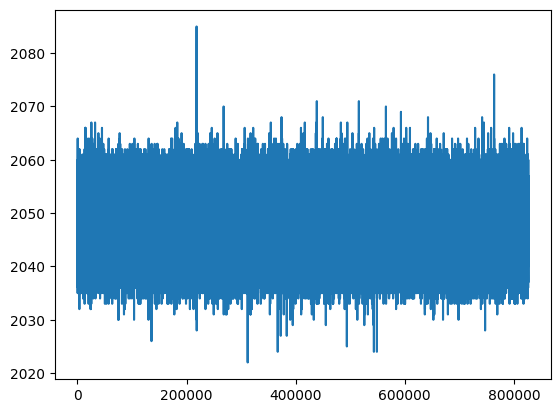

In [5]:
plt.plot(raw_voltages[:, 2])
plt.show()

Plot the raw traces.

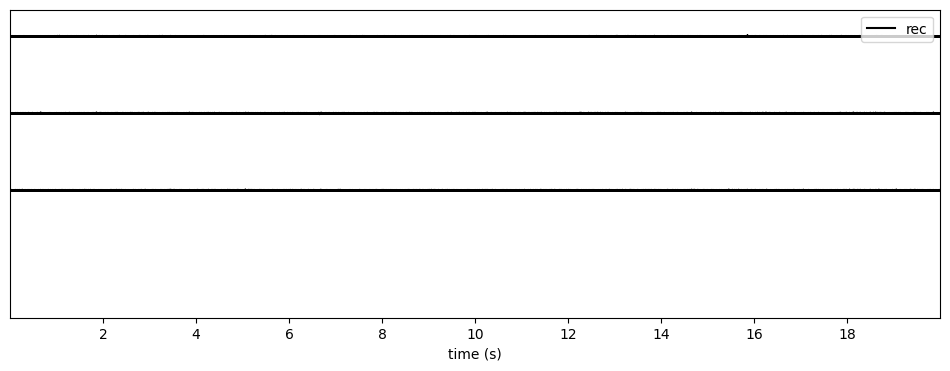

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
si.plot_traces(RX, time_range=[0,20], ax=ax, channel_ids=chans, color='k')

## Pre-processing
---

In [7]:
# RX_filtered = st.BlankSaturationRecording(RX, quantile_threshold=0.999)
# RX_filtered = st.normalize_by_quantile(RX_filtered, scale=20)

Bandpass filter.

In [8]:
RX_filtered_bpass = si.bandpass_filter(RX, freq_min=300, freq_max=3000)
RX_filtered_bpass

BandpassFilterRecording: 4096 channels - 13.8kHz - 1 segments - 2,066,017 samples 
                         150.00s (2.50 minutes) - int16 dtype - 15.76 GiB

Remove bad channels.

In [9]:
# # detect
# bad_channel_ids, channel_labels = st.detect_bad_channels(recording=RX_filtered_bpass)
# # Case 1 : remove then
# rec_clean = RX_filtered_bpass.remove_channels(remove_channel_ids=bad_channel_ids)

# print(f'Bad channels: {bad_channel_ids}')

Common median reference.

In [10]:
recording_cmr = st.common_reference(recording=RX_filtered_bpass, operator="median")

Normalize the recordings. Apply the gains and offsets.

In [11]:
# rec_normed = st.zscore(recording=recording_cmr)

Bandpass filter and re-plot the data.

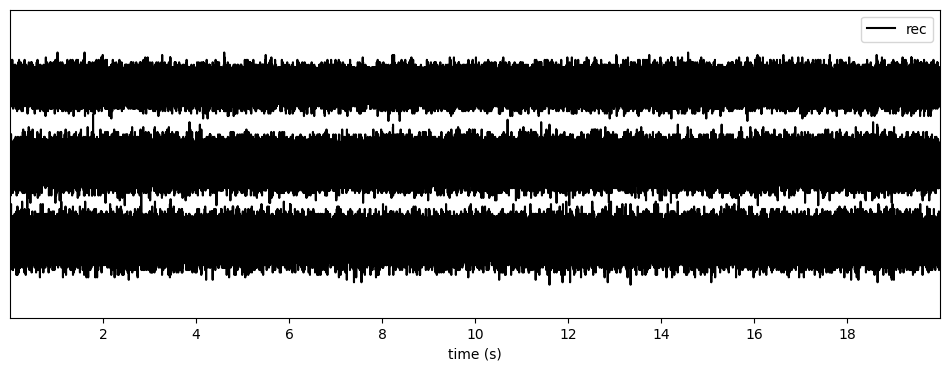

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
si.plot_traces(recording_cmr, time_range=[0,20], ax=ax, channel_ids=chans)

## Spike-sorting
-----

First, check the available sorters.

In [13]:
import spikeinterface.sorters as ss
ss.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'kilosort4',
 'klusta',
 'mountainsort4',
 'mountainsort5',
 'pykilosort',
 'simple',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2',
 'waveclus',
 'waveclus_snippets',
 'yass']

Set the default sorting parameters.

In [14]:
sorter_params = si.get_default_sorter_params('herdingspikes')
sorter_params

{'clustering_bandwidth': 5.5,
 'clustering_alpha': 5.5,
 'clustering_n_jobs': -1,
 'clustering_bin_seeding': True,
 'clustering_min_bin_freq': 16,
 'clustering_subset': None,
 'left_cutout_time': 0.3,
 'right_cutout_time': 1.8,
 'detect_threshold': 20,
 'probe_masked_channels': [],
 'probe_inner_radius': 70,
 'probe_neighbor_radius': 90,
 'probe_event_length': 0.26,
 'probe_peak_jitter': 0.2,
 't_inc': 100000,
 'num_com_centers': 1,
 'maa': 12,
 'ahpthr': 11,
 'out_file_name': 'HS2_detected',
 'decay_filtering': False,
 'save_all': False,
 'amp_evaluation_time': 0.4,
 'spk_evaluation_time': 1.0,
 'pca_ncomponents': 2,
 'pca_whiten': True,
 'freq_min': 300.0,
 'freq_max': 6000.0,
 'filter': True,
 'pre_scale': True,
 'pre_scale_value': 20.0,
 'filter_duplicates': True}

In [15]:
# loading kwargs
n_cpus = os.cpu_count()
n_jobs = n_cpus - 4
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="1s", progress_bar=True)

# create an object, passing the recording extractor
hs = si.run_sorter(sorter_name='herdingspikes', recording=recording_cmr, output_folder='data/hs_output', docker_image=True, verbose=True, **sorter_params)

C:\Users\michael.zabolocki\AppData\Local\Temp\ipykernel_15336\1764157186.py:10: DeprecationWarning: `output_folder` is deprecated and will be removed in version 0.103.0 Please use folder instead
  hs = si.run_sorter(sorter_name='herdingspikes', recording=recording_cmr, output_folder='data/hs_output', docker_image=True, verbose=True, **sorter_params, **job_kwargs)


installation_mode='auto' switching to installation_mode: 'github'
Starting container
Installing spikeinterface with github in container
Installing neo with pypi in container
Running herdingspikes sorter inside spikeinterface/herdingspikes-base
Stopping container


SpikeSortingError: Spike sorting in docker failed with the following error:
/Users/michael.zabolocki/Documents/code/3brain_gradelab/data/in_container_sorter_script.py:23: DeprecationWarning: `output_folder` is deprecated and will be removed in version 0.103.0 Please use folder instead
  sorting = run_sorter_local(
Traceback (most recent call last):
  File "/Users/michael.zabolocki/Documents/code/3brain_gradelab/data/in_container_sorter_script.py", line 23, in <module>
    sorting = run_sorter_local(
  File "/root/.local/lib/python3.8/site-packages/spikeinterface/sorters/runsorter.py", line 274, in run_sorter_local
    SorterClass.set_params_to_folder(recording, folder, sorter_params, verbose)
  File "/root/.local/lib/python3.8/site-packages/spikeinterface/sorters/basesorter.py", line 183, in set_params_to_folder
    raise ValueError(error_msg)
ValueError: Invalid parameters: ['n_jobs', 'chunk_duration', 'progress_bar'] 
Valid parameters are: dict_keys(['clustering_bandwidth', 'clustering_alpha', 'clustering_n_jobs', 'clustering_bin_seeding', 'clustering_min_bin_freq', 'clustering_subset', 'left_cutout_time', 'right_cutout_time', 'detect_threshold', 'probe_masked_channels', 'probe_inner_radius', 'probe_neighbor_radius', 'probe_event_length', 'probe_peak_jitter', 't_inc', 'num_com_centers', 'maa', 'ahpthr', 'out_file_name', 'decay_filtering', 'save_all', 'amp_evaluation_time', 'spk_evaluation_time', 'pca_ncomponents', 'pca_whiten', 'freq_min', 'freq_max', 'filter', 'pre_scale', 'pre_scale_value', 'filter_duplicates'])
